# Kinodynamic Diffusion Planner
## Diffusion Models for Kinodynamic Constraint Satisfaction

**Complete Implementation in Google Colab**

This notebook implements a trajectory planning system that:
1. Learns to generate control sequences using diffusion models
2. Enforces kinodynamic constraints via proximal projection
3. Guarantees obstacle avoidance using signed distance fields

---

### 📋 Sections:
1. **Setup & Installation**
2. **Module 1: Dynamics** - Differentiable forward simulation
3. **Module 2: Diffusion Model** - Temporal U-Net for control sequences
4. **Module 3: Constraints** - SDF + Proximal Projection
5. **Module 4: Dataset** - Synthetic maze trajectories
6. **Training** - Train the diffusion model
7. **Evaluation** - Test with constraint projection
8. **Visualizations** - Compare results
9. **Ablation Studies** - Systematic experiments

**⚡ Quick Start:** Run all cells in order!

---
## 1. Setup & Installation

In [26]:
# Install required packages
!pip install torch torchvision torchaudio --quiet
!pip install matplotlib tqdm --quiet

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, LBFGS
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.animation import FuncAnimation
from tqdm.notebook import tqdm
import pickle
from IPython.display import HTML

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

print("\n✓ Setup complete!")

Using device: cpu

✓ Setup complete!


---
## 2. Module 1: Dynamics

Implements differentiable dynamics for trajectory rollout.

**Key Classes:**
- `BaseDynamics`: Abstract dynamics interface
- `SingleIntegrator2D`: Simple position control (state=[x,y], control=[vx,vy])
- `PointMass2D`: With velocity dynamics (state=[x,y,vx,vy], control=[ax,ay])
- `DifferentiableRollout`: Rolls out controls through dynamics with gradient flow

In [27]:
class BaseDynamics(nn.Module):
    """Abstract base class for dynamics models"""

    def __init__(self, state_dim, control_dim, dt=0.1):
        super().__init__()
        self.state_dim = state_dim
        self.control_dim = control_dim
        self.dt = dt

    def forward(self, x, u):
        raise NotImplementedError


class PointMass2D(BaseDynamics):
    """2D point mass with velocity: state=[x,y,vx,vy], control=[ax,ay]"""

    def __init__(self, dt=0.1, max_velocity=2.0, damping=0.9):
        super().__init__(state_dim=4, control_dim=2, dt=dt)
        self.max_velocity = max_velocity
        self.damping = damping

    def forward(self, x, u):
        pos = x[..., :2]
        vel = x[..., 2:]

        vel_new = self.damping * vel + self.dt * u
        vel_new = torch.clamp(vel_new, -self.max_velocity, self.max_velocity)
        pos_new = pos + self.dt * vel_new

        return torch.cat([pos_new, vel_new], dim=-1)


class SingleIntegrator2D(BaseDynamics):
    """Simple velocity control: state=[x,y], control=[vx,vy]"""

    def __init__(self, dt=0.1):
        super().__init__(state_dim=2, control_dim=2, dt=dt)

    def forward(self, x, u):
        return x + self.dt * u


class DifferentiableRollout(nn.Module):
    """Roll out controls through dynamics (enables backprop)"""

    def __init__(self, dynamics):
        super().__init__()
        self.dynamics = dynamics

    def forward(self, x0, controls):
        batch_size, T = controls.shape[:2]
        state_dim = self.dynamics.state_dim

        states = torch.zeros(batch_size, T + 1, state_dim,
                           device=x0.device, dtype=x0.dtype)
        states[:, 0] = x0

        x = x0
        for t in range(T):
            u = controls[:, t]
            x = self.dynamics(x, u)
            states[:, t + 1] = x

        return states


# Test
print("Testing dynamics...")
dynamics = SingleIntegrator2D()
rollout = DifferentiableRollout(dynamics)
x0 = torch.zeros(2, 2)
controls = torch.randn(2, 10, 2)
states = rollout(x0, controls)
print(f"✓ Rollout shape: {states.shape} (batch=2, T+1=11, state_dim=2)")

Testing dynamics...
✓ Rollout shape: torch.Size([2, 11, 2]) (batch=2, T+1=11, state_dim=2)


---
## 3. Module 2: Diffusion Model

Temporal U-Net for denoising control sequences + DDPM implementation.

**Architecture:**
- Sinusoidal time embeddings for diffusion step k
- 1D temporal convolutions for sequence processing
- U-Net with skip connections
- FiLM conditioning on time and task (start, goal)

In [28]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        emb = np.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([emb.sin(), emb.cos()], dim=-1)
        return emb


class TemporalConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.norm = nn.GroupNorm(min(8, out_channels), out_channels)
        self.act = nn.Mish()

    def forward(self, x):
        return self.act(self.norm(self.conv(x)))


class TemporalUNet(nn.Module):
    """
    Temporal U-Net for denoising control sequences.

    IMPORTANT FIX:
    The original notebook computed a condition embedding but never used it,
    which effectively made the diffusion model unconditional. This version
    injects the condition embedding at multiple resolutions (FiLM-style additive bias),
    so the model can actually plan conditioned on (x0, x_goal).
    """

    def __init__(self, control_dim, hidden_dim=128, time_emb_dim=64, cond_dim=32):
        super().__init__()
        self.control_dim = control_dim

        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim * 4),
            nn.Mish(),
            nn.Linear(time_emb_dim * 4, time_emb_dim)
        )

        self.cond_encoder = nn.Sequential(
            nn.Linear(cond_dim, hidden_dim),
            nn.Mish(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        # Encoder
        self.enc1 = TemporalConvBlock(control_dim, hidden_dim // 2)
        self.enc2 = TemporalConvBlock(hidden_dim // 2, hidden_dim)
        self.enc3 = TemporalConvBlock(hidden_dim, hidden_dim * 2)

        # Bottleneck
        self.bottleneck = TemporalConvBlock(hidden_dim * 2, hidden_dim * 2)

        # Decoder
        self.dec3 = TemporalConvBlock(hidden_dim * 4, hidden_dim)
        self.dec2 = TemporalConvBlock(hidden_dim * 2, hidden_dim // 2)
        self.dec1 = TemporalConvBlock(hidden_dim, hidden_dim // 2)

        self.out = nn.Conv1d(hidden_dim // 2, control_dim, 1)

        # Time modulation (additive)
        self.time_mod = nn.ModuleList([
            nn.Linear(time_emb_dim, hidden_dim // 2),
            nn.Linear(time_emb_dim, hidden_dim),
            nn.Linear(time_emb_dim, hidden_dim * 2),
            nn.Linear(time_emb_dim, hidden_dim * 2),
        ])

        # Condition modulation (additive)
        self.cond_mod = nn.ModuleList([
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.Linear(hidden_dim, hidden_dim * 2),
        ])

    def forward(self, u_noisy, k, condition):
        # u_noisy: [B, T, control_dim]
        x = u_noisy.transpose(1, 2)  # [B, control_dim, T]

        t_emb = self.time_mlp(k)                 # [B, time_emb_dim]
        c_emb = self.cond_encoder(condition)     # [B, hidden_dim]

        # Encoder
        e1 = self.enc1(x) + self.time_mod[0](t_emb)[:, :, None] + self.cond_mod[0](c_emb)[:, :, None]
        e2_in = F.avg_pool1d(e1, 2)
        e2 = self.enc2(e2_in) + self.time_mod[1](t_emb)[:, :, None] + self.cond_mod[1](c_emb)[:, :, None]

        e3_in = F.avg_pool1d(e2, 2)
        e3 = self.enc3(e3_in) + self.time_mod[2](t_emb)[:, :, None] + self.cond_mod[2](c_emb)[:, :, None]

        # Bottleneck
        b_in = F.avg_pool1d(e3, 2)
        b = self.bottleneck(b_in) + self.time_mod[3](t_emb)[:, :, None] + self.cond_mod[3](c_emb)[:, :, None]

        # Decoder with skip connections
        d3 = F.interpolate(b, size=e3.shape[-1], mode='linear', align_corners=False)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))

        d2 = F.interpolate(d3, size=e2.shape[-1], mode='linear', align_corners=False)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = F.interpolate(d2, size=e1.shape[-1], mode='linear', align_corners=False)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        out = self.out(d1)  # [B, control_dim, T]
        return out.transpose(1, 2)  # [B, T, control_dim]


class ControlDiffusion(nn.Module):
    """DDPM for control sequences"""

    def __init__(self, denoiser, T_diffusion=100, beta_schedule='linear'):
        super().__init__()
        self.denoiser = denoiser
        self.T_diffusion = T_diffusion

        if beta_schedule == 'linear':
            betas = torch.linspace(1e-4, 0.02, T_diffusion)
        else:
            s = 0.008
            steps = T_diffusion + 1
            x = torch.linspace(0, T_diffusion, steps)
            alphas_cumprod = torch.cos(((x / T_diffusion) + s) / (1 + s) * np.pi * 0.5) ** 2
            alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
            betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
            betas = torch.clamp(betas, 0, 0.999)

        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)

        self.register_buffer('betas', betas)
        self.register_buffer('alphas', alphas)
        self.register_buffer('alphas_cumprod', alphas_cumprod)
        self.register_buffer('sqrt_alphas_cumprod', torch.sqrt(alphas_cumprod))
        self.register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1.0 - alphas_cumprod))

    def q_sample(self, u0, k, noise=None):
        if noise is None:
            noise = torch.randn_like(u0)

        sqrt_alpha_cumprod = self.sqrt_alphas_cumprod[k][:, None, None]
        sqrt_one_minus = self.sqrt_one_minus_alphas_cumprod[k][:, None, None]

        u_k = sqrt_alpha_cumprod * u0 + sqrt_one_minus * noise
        return u_k, noise

    def p_sample(self, u_k, k, condition):
        noise_pred = self.denoiser(u_k, k, condition)

        alpha = self.alphas[k][:, None, None]
        alpha_cumprod = self.alphas_cumprod[k][:, None, None]
        alpha_cumprod_prev = self.alphas_cumprod[k - 1][:, None, None] if k[0] > 0 else torch.ones_like(alpha_cumprod)

        pred_u0 = (u_k - torch.sqrt(1 - alpha_cumprod) * noise_pred) / torch.sqrt(alpha_cumprod)
        dir_uk = torch.sqrt(1 - alpha_cumprod_prev) * noise_pred
        u_k_minus_1 = torch.sqrt(alpha_cumprod_prev) * pred_u0 + dir_uk

        if k[0] > 0:
            noise = torch.randn_like(u_k)
            sigma = torch.sqrt(self.betas[k])[:, None, None]
            u_k_minus_1 = u_k_minus_1 + sigma * noise

        return u_k_minus_1

    @torch.no_grad()
    def sample(self, shape, condition):
        device = self.betas.device
        u = torch.randn(shape, device=device)

        for i in reversed(range(self.T_diffusion)):
            k = torch.full((shape[0],), i, device=device, dtype=torch.long)
            u = self.p_sample(u, k, condition)

        return u


print("✓ Diffusion model defined (conditioning FIXED)")


✓ Diffusion model defined (conditioning FIXED)


---
## 4. Module 3: Constraints

**Signed Distance Field (SDF)** for obstacles + **Proximal Projection** for feasibility.

**Key idea:** After each denoising step, solve:
```
u* = argmin ||u - ũ||² + λ Φ(u)
```
where Φ penalizes goal error, collisions, and control effort.

In [29]:
class SignedDistanceField2D:
    """
    2D Signed Distance Field for circular obstacles.

    IMPORTANT FIX:
    The original notebook sampled from a precomputed grid using floor()/integer indexing.
    That breaks gradient flow w.r.t. position and makes the obstacle term effectively non-differentiable.
    This version returns an analytic circle SDF (fully differentiable almost everywhere), while still
    precomputing a grid for visualization if desired.
    """

    def __init__(self, obstacles, grid_size=100, bounds=(-1, 1), precompute_grid=True):
        self.obstacles = obstacles
        self.grid_size = grid_size
        self.bounds = bounds

        # tensors for fast, differentiable queries
        centers = torch.tensor([c for (c, r) in obstacles], dtype=torch.float32)
        radii = torch.tensor([r for (c, r) in obstacles], dtype=torch.float32)
        self.centers = centers   # [N, 2]
        self.radii = radii       # [N]

        self.sdf_grid = None
        if precompute_grid:
            self.sdf_grid = self._compute_sdf_grid()

    def _compute_sdf_grid(self):
        x = torch.linspace(self.bounds[0], self.bounds[1], self.grid_size)
        y = torch.linspace(self.bounds[0], self.bounds[1], self.grid_size)
        xx, yy = torch.meshgrid(x, y, indexing='ij')
        pts = torch.stack([xx, yy], dim=-1)  # [H, W, 2]
        sdf = self(pts)  # analytic query
        return sdf

    def __call__(self, positions):
        # positions: [..., 2]
        pos = positions
        centers = self.centers.to(pos.device, dtype=pos.dtype)  # [N,2]
        radii = self.radii.to(pos.device, dtype=pos.dtype)      # [N]

        diff = pos[..., None, :] - centers  # [..., N, 2]
        dist = torch.sqrt(torch.sum(diff * diff, dim=-1) + 1e-9)  # [..., N]
        sdf_all = dist - radii  # [..., N]
        sdf = torch.min(sdf_all, dim=-1).values  # [...]
        return sdf


class ConstraintFunction(nn.Module):
    """Differentiable constraint/cost function Φ(u)"""

    def __init__(self, dynamics, sdf, delta=0.05,
                 goal_weight=10.0, obstacle_weight=100.0, control_weight=0.1, smooth_weight=0.0):
        super().__init__()
        self.dynamics = dynamics
        self.sdf = sdf
        self.delta = delta
        self.goal_weight = goal_weight
        self.obstacle_weight = obstacle_weight
        self.control_weight = control_weight
        self.smooth_weight = smooth_weight

    def forward(self, controls, x0, x_goal, return_components=False):
        batch_size, T = controls.shape[:2]
        device = controls.device

        # Rollout
        states = torch.zeros(batch_size, T + 1, self.dynamics.state_dim, device=device)
        states[:, 0] = x0
        x = x0
        for t in range(T):
            u = controls[:, t]
            x = self.dynamics(x, u)
            states[:, t + 1] = x

        positions = states[..., :2]

        # Goal cost
        final_pos = positions[:, -1]
        goal_pos = x_goal if x_goal.shape[-1] == 2 else x_goal[..., :2]
        goal_cost = torch.sum((final_pos - goal_pos) ** 2, dim=-1)

        # Obstacle cost (soft barrier)
        sdf_values = self.sdf(positions)  # [B, T+1]
        obstacle_penetration = F.relu(self.delta - sdf_values)
        obstacle_cost = torch.sum(obstacle_penetration ** 2, dim=-1)

        # Control effort
        control_cost = torch.sum(controls ** 2, dim=(1, 2))

        # Smoothness (optional)
        smooth_cost = torch.zeros_like(goal_cost)
        if self.smooth_weight > 0 and T >= 2:
            du = controls[:, 1:] - controls[:, :-1]
            smooth_cost = torch.sum(du ** 2, dim=(1, 2))

        total_cost = (self.goal_weight * goal_cost +
                      self.obstacle_weight * obstacle_cost +
                      self.control_weight * control_cost +
                      self.smooth_weight * smooth_cost)

        if return_components:
            components = {
                'goal': goal_cost.mean().item(),
                'obstacle': obstacle_cost.mean().item(),
                'control': control_cost.mean().item(),
                'smooth': smooth_cost.mean().item() if self.smooth_weight > 0 else 0.0,
                'total': total_cost.mean().item()
            }
            return total_cost, components

        return total_cost


class ProximalProjection(nn.Module):
    """Proximal operator for constraint satisfaction"""

    def __init__(self, constraint_fn, lambda_penalty=0.1, num_steps=10, lr=0.01, u_clip=None):
        super().__init__()
        self.constraint_fn = constraint_fn
        self.lambda_penalty = lambda_penalty
        self.num_steps = num_steps
        self.lr = lr
        self.u_clip = u_clip

    def project(self, u_tilde, x0, x_goal, verbose=False):
        u = u_tilde.clone().detach().requires_grad_(True)
        optimizer = Adam([u], lr=self.lr)

        losses = []
        for step in range(self.num_steps):
            optimizer.zero_grad()

            proximal_loss = torch.mean((u - u_tilde) ** 2)
            constraint_loss, components = self.constraint_fn(u, x0, x_goal, return_components=True)
            constraint_loss = constraint_loss.mean()

            total_loss = proximal_loss + self.lambda_penalty * constraint_loss
            total_loss.backward()
            optimizer.step()

            if self.u_clip is not None:
                with torch.no_grad():
                    u.clamp_(-self.u_clip, self.u_clip)

            losses.append(total_loss.item())

        info = {'losses': losses, 'final_constraint': components}
        return u.detach(), info


class FeasibleDiffusionSampler(nn.Module):
    """Complete sampling with constraint projection"""

    def __init__(self, diffusion_model, proximal_projection, project_every=1):
        super().__init__()
        self.diffusion = diffusion_model
        self.projection = proximal_projection
        self.project_every = project_every

    @torch.no_grad()
    def sample(self, batch_size, T, x0, x_goal, verbose=False):
        device = next(self.diffusion.parameters()).device
        control_dim = self.diffusion.denoiser.control_dim

        # Prepare conditioning
        if x_goal.shape[-1] == x0.shape[-1]:
            condition = torch.cat([x0, x_goal], dim=-1)
        else:
            goal_padded = torch.zeros_like(x0)
            goal_padded[..., :x_goal.shape[-1]] = x_goal
            condition = torch.cat([x0, goal_padded], dim=-1)

        u = torch.randn(batch_size, T, control_dim, device=device)

        for i in reversed(range(self.diffusion.T_diffusion)):
            k = torch.full((batch_size,), i, device=device, dtype=torch.long)
            u = self.diffusion.p_sample(u, k, condition)

            if i % self.project_every == 0:
                # Projection uses gradients; re-enable autograd even if sampling is run under no_grad
                with torch.enable_grad():
                    u, _ = self.projection.project(u, x0, x_goal, verbose=verbose)

        return u, {}


print("✓ Constraint layer defined (SDF gradients FIXED)")


✓ Constraint layer defined (SDF gradients FIXED)


---
## 5. Module 4: Dataset

Synthetic maze navigation trajectories with smooth paths.

In [30]:
class MazeDataset(Dataset):
    """
    Synthetic dataset of FEASIBLE trajectories in a 2D maze with circular obstacles.

    IMPORTANT FIX:
    The original dataset used random Bézier curves and did NOT enforce obstacle avoidance,
    so the diffusion model was trained on collision trajectories. This version generates
    trajectories by solving a small differentiable optimal control problem per sample.
    """
    def __init__(
        self,
        num_trajectories=1000,
        horizon=20,
        dynamics_type='single_integrator',
        dt=0.1,
        delta=0.05,
        planner_steps=60,
        planner_lr=0.15,
        u_clip=3.0,
        min_goal_dist=0.4,
        seed=0,
    ):
        super().__init__()
        rng = np.random.RandomState(seed)
        self.horizon = horizon
        self.dynamics_type = dynamics_type
        self.dt = dt
        self.delta = delta
        self.u_clip = u_clip
        self.min_goal_dist = min_goal_dist

        self.obstacles = self._create_obstacles()
        self.sdf = SignedDistanceField2D(self.obstacles, grid_size=80, bounds=(-1, 1), precompute_grid=True)

        if self.dynamics_type == 'single_integrator':
            self.dynamics = SingleIntegrator2D(dt=dt)
            self.state_dim = 2
            self.control_dim = 2
        else:
            self.dynamics = PointMass2D(dt=dt)
            self.state_dim = 4
            self.control_dim = 2

        self.rollout = DifferentiableRollout(self.dynamics)

        # Cost used both for data generation and for projection
        self.constraint_fn = ConstraintFunction(
            self.dynamics,
            self.sdf,
            delta=delta,
            goal_weight=25.0,
            obstacle_weight=400.0,
            control_weight=0.001,
            smooth_weight=0.02,
        )

        # Generate feasible data
        self.trajectories = self._generate_data(
            num_trajectories=num_trajectories,
            planner_steps=planner_steps,
            planner_lr=planner_lr,
            u_clip=u_clip,
            rng=rng,
        )

    def _create_obstacles(self):
        # fixed obstacle layout (can be randomized later)
        return [
            ((0.0, 0.3), 0.15),
            ((-0.4, -0.3), 0.2),
            ((0.5, -0.5), 0.15),
        ]

    def _sample_start_goal(self, n, rng):
        starts = rng.uniform(-0.8, 0.8, size=(n, 2)).astype(np.float32)
        goals  = rng.uniform(-0.8, 0.8, size=(n, 2)).astype(np.float32)
        return torch.from_numpy(starts), torch.from_numpy(goals)

    @torch.no_grad()
    def _valid_start_goal_mask(self, starts, goals):
        # starts/goals: [N,2]
        sdf_s = self.sdf(starts)  # [N]
        sdf_g = self.sdf(goals)
        far_enough = torch.norm(starts - goals, dim=-1) > self.min_goal_dist
        return (sdf_s > self.delta) & (sdf_g > self.delta) & far_enough

    def _solve_batch(self, x0_pos, x_goal, planner_steps, planner_lr, u_clip):
        """
        Solve a small optimal control problem for a batch of start/goal pairs.
        Returns: controls [B,T,2], states [B,T+1,state_dim]
        """
        device = x0_pos.device
        B = x0_pos.shape[0]
        T = self.horizon

        # initial state
        if self.dynamics_type == 'single_integrator':
            x0 = x0_pos
        else:
            x0 = torch.cat([x0_pos, torch.zeros_like(x0_pos)], dim=-1)

        # straight-line initialization (velocity control)
        u0 = (x_goal - x0_pos) / (self.dt * T)
        u = u0[:, None, :].repeat(1, T, 1)
        u = u + 0.25 * torch.randn_like(u)
        u = u.clone().requires_grad_(True)

        opt = Adam([u], lr=planner_lr)

        for _ in range(planner_steps):
            opt.zero_grad()
            cost = self.constraint_fn(u, x0, x_goal)  # [B]
            loss = cost.mean()
            loss.backward()
            opt.step()

            with torch.no_grad():
                u.clamp_(-u_clip, u_clip)

        with torch.no_grad():
            states = self.rollout(x0, u.detach())
        return u.detach(), states

    def _generate_data(self, num_trajectories, planner_steps, planner_lr, u_clip, rng):
        trajectories = []
        target = num_trajectories

        # Generate in batches for speed
        gen_batch = 128

        while len(trajectories) < target:
            # Oversample because some pairs/solutions will be rejected
            starts, goals = self._sample_start_goal(gen_batch * 2, rng)
            mask = self._valid_start_goal_mask(starts, goals)
            starts = starts[mask]
            goals = goals[mask]

            if starts.shape[0] == 0:
                continue

            # cap batch
            B = min(gen_batch, starts.shape[0])
            starts = starts[:B]
            goals = goals[:B]

            controls, states = self._solve_batch(
                x0_pos=starts,
                x_goal=goals,
                planner_steps=planner_steps,
                planner_lr=planner_lr,
                u_clip=u_clip
            )

            positions = states[..., :2]
            sdf_vals = self.sdf(positions)                  # [B, T+1]
            min_clear = sdf_vals.min(dim=1).values          # [B]
            goal_err = torch.norm(positions[:, -1] - goals, dim=-1)  # [B]

            good = (min_clear > 0.0) & (goal_err < 0.15)

            for i in torch.where(good)[0].tolist():
                trajectories.append({
                    'states': states[i].cpu().numpy().astype(np.float32),
                    'controls': controls[i].cpu().numpy().astype(np.float32),
                    'start': starts[i].cpu().numpy().astype(np.float32),
                    'goal': goals[i].cpu().numpy().astype(np.float32),
                })

            if len(trajectories) % 200 == 0 and len(trajectories) > 0:
                print(f"  generated {len(trajectories)}/{target} feasible trajectories...")

        return trajectories[:target]

    def __len__(self):
        return len(self.trajectories)

    def __getitem__(self, idx):
        traj = self.trajectories[idx]
        return {
            'controls': torch.from_numpy(traj['controls']),
            'states': torch.from_numpy(traj['states']),
            'x0': torch.from_numpy(traj['states'][0]),
            'x_goal': torch.from_numpy(traj['goal']),
        }


def collate_fn(batch):
    return {
        'controls': torch.stack([x['controls'] for x in batch]),
        'states': torch.stack([x['states'] for x in batch]),
        'x0': torch.stack([x['x0'] for x in batch]),
        'x_goal': torch.stack([x['x_goal'] for x in batch]),
    }


def create_condition_encoding(x0, x_goal, state_dim=2):
    batch_size = x0.shape[0]
    if x_goal.shape[-1] < state_dim:
        goal_padded = torch.zeros(batch_size, state_dim, device=x0.device, dtype=x0.dtype)
        goal_padded[:, :x_goal.shape[-1]] = x_goal
        x_goal = goal_padded
    return torch.cat([x0[..., :state_dim], x_goal], dim=-1)


print("✓ Dataset defined (feasible trajectories)")


✓ Dataset defined (feasible trajectories)


---
## 6. Training

Train the diffusion model to denoise control sequences.

In [31]:
# Configuration
config = {
    'dynamics_type': 'single_integrator',
    'dt': 0.1,
    'horizon': 15,
    'state_dim': 2,
    'control_dim': 2,
    'hidden_dim': 96,
    'cond_dim': 4,
    'T_diffusion': 50,
    'num_train_trajectories': 1200,
    'batch_size': 32,
    'num_epochs': 25,
    'learning_rate': 3e-4,
}

print("Configuration:")
for k, v in config.items():
    print(f"  {k}: {v}")

Configuration:
  dynamics_type: single_integrator
  dt: 0.1
  horizon: 15
  state_dim: 2
  control_dim: 2
  hidden_dim: 96
  cond_dim: 4
  T_diffusion: 50
  num_train_trajectories: 1200
  batch_size: 32
  num_epochs: 25
  learning_rate: 0.0003


In [32]:
# Create dataset and dataloader
print("Creating dataset...")
train_dataset = MazeDataset(
    num_trajectories=config['num_train_trajectories'],
    horizon=config['horizon'],
    dynamics_type=config['dynamics_type']
)

train_loader = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    collate_fn=collate_fn
)

print(f"✓ Dataset: {len(train_dataset)} trajectories")
print(f"✓ Obstacles: {len(train_dataset.obstacles)} circular obstacles")

Creating dataset...
✓ Dataset: 1200 trajectories
✓ Obstacles: 3 circular obstacles


In [33]:
# Create model
print("Creating diffusion model...")

denoiser = TemporalUNet(
    control_dim=config['control_dim'],
    hidden_dim=config['hidden_dim'],
    cond_dim=config['cond_dim']
).to(device)

diffusion_model = ControlDiffusion(
    denoiser,
    T_diffusion=config['T_diffusion']
).to(device)

optimizer = Adam(diffusion_model.parameters(), lr=config['learning_rate'])

# Count parameters
total_params = sum(p.numel() for p in diffusion_model.parameters())
print(f"✓ Model created: {total_params:,} parameters")

Creating diffusion model...
✓ Model created: 462,738 parameters


In [9]:
# Training loop
print("\nStarting training...\n")

diffusion_model.train()
loss_history = []

for epoch in range(config['num_epochs']):
    epoch_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['num_epochs']}")

    for batch in pbar:
        controls = batch['controls'].to(device)
        x0 = batch['x0'].to(device)
        x_goal = batch['x_goal'].to(device)

        batch_size = controls.shape[0]

        # Conditioning
        condition = create_condition_encoding(x0, x_goal, state_dim=config['state_dim'])

        # Random timestep
        k = torch.randint(0, config['T_diffusion'], (batch_size,), device=device)

        # Forward diffusion
        u_noisy, noise_true = diffusion_model.q_sample(controls, k)

        # Predict noise
        noise_pred = denoiser(u_noisy, k, condition)

        # Loss
        loss = F.mse_loss(noise_pred, noise_true)

        # Optimize
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(diffusion_model.parameters(), 1.0)
        optimizer.step()

        epoch_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    avg_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1} - Avg Loss: {avg_loss:.4f}")

print("\n✓ Training complete!")


Starting training...



Epoch 1/25:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 1 - Avg Loss: 0.6641


Epoch 2/25:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 2 - Avg Loss: 0.4613


Epoch 3/25:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 3 - Avg Loss: 0.4291


Epoch 4/25:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 4 - Avg Loss: 0.4167


Epoch 5/25:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 5 - Avg Loss: 0.3860


Epoch 6/25:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 6 - Avg Loss: 0.3723


Epoch 7/25:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 7 - Avg Loss: 0.3756


Epoch 8/25:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 8 - Avg Loss: 0.3682


Epoch 9/25:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 9 - Avg Loss: 0.3619


Epoch 10/25:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 10 - Avg Loss: 0.3684


Epoch 11/25:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 11 - Avg Loss: 0.3564


Epoch 12/25:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 12 - Avg Loss: 0.3480


Epoch 13/25:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 13 - Avg Loss: 0.3446


Epoch 14/25:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 14 - Avg Loss: 0.3299


Epoch 15/25:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 15 - Avg Loss: 0.3486


Epoch 16/25:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 16 - Avg Loss: 0.3421


Epoch 17/25:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 17 - Avg Loss: 0.3238


Epoch 18/25:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 18 - Avg Loss: 0.3393


Epoch 19/25:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 19 - Avg Loss: 0.3276


Epoch 20/25:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 20 - Avg Loss: 0.3320


Epoch 21/25:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 21 - Avg Loss: 0.3287


Epoch 22/25:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 22 - Avg Loss: 0.3209


Epoch 23/25:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 23 - Avg Loss: 0.3295


Epoch 24/25:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 24 - Avg Loss: 0.3364


Epoch 25/25:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 25 - Avg Loss: 0.3250

✓ Training complete!


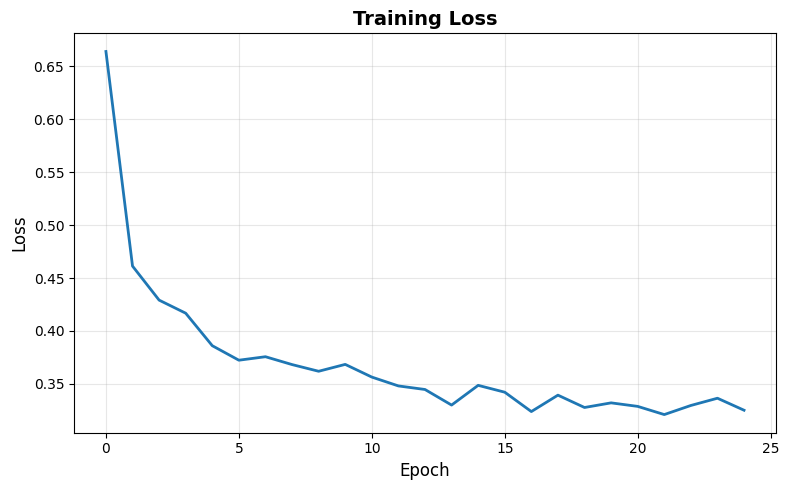

Final loss: 0.3250


In [10]:
# Plot training curve
plt.figure(figsize=(8, 5))
plt.plot(loss_history, linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final loss: {loss_history[-1]:.4f}")

---
## 7. Evaluation

Test the planner with and without constraint projection.

In [11]:
# Setup for evaluation
dynamics = SingleIntegrator2D(dt=config['dt'])
rollout = DifferentiableRollout(dynamics)

# Obstacles (same layout as training data)
obstacles = train_dataset.obstacles
sdf = SignedDistanceField2D(obstacles, grid_size=80, bounds=(-1, 1))

# Constraint/cost (match the data generator so projection is meaningful)
constraint_fn = ConstraintFunction(
    dynamics, sdf,
    delta=0.05,
    goal_weight=25.0,
    obstacle_weight=400.0,
    control_weight=0.001,
    smooth_weight=0.02
)

# Proximal projection
projection = ProximalProjection(
    constraint_fn,
    lambda_penalty=0.1,
    num_steps=6,
    lr=0.06,
    u_clip=3.0
)

# Complete sampler
sampler = FeasibleDiffusionSampler(
    diffusion_model,
    projection,
    project_every=10
)

print("✓ Evaluation setup complete")


✓ Evaluation setup complete


In [12]:
# Test scenario
x0 = torch.tensor([[-0.7, -0.7]], dtype=torch.float32, device=device)
x_goal = torch.tensor([[0.7, 0.7]], dtype=torch.float32, device=device)

print("Planning WITHOUT projection...")
diffusion_model.eval()
condition = create_condition_encoding(x0, x_goal, state_dim=config['state_dim'])
controls_no_proj = diffusion_model.sample(
    shape=(1, config['horizon'], config['control_dim']),
    condition=condition
)
states_no_proj = rollout(x0, controls_no_proj)

print("Planning WITH projection...")
controls_proj, _ = sampler.sample(
    batch_size=1,
    T=config['horizon'],
    x0=x0,
    x_goal=x_goal
)
states_proj = rollout(x0, controls_proj)

print("✓ Both trajectories generated")

Planning WITHOUT projection...
Planning WITH projection...
✓ Both trajectories generated


---
## 8. Visualization

Compare trajectories with and without constraint projection.

In [13]:
# Evaluate both trajectories
def evaluate_trajectory(states, x_goal, sdf, name, goal_tol=0.15):
    final_pos = states[0, -1, :2]
    goal_error = torch.norm(final_pos - x_goal[0]).item()

    positions = states[0, :, :2]
    sdf_vals = sdf(positions)
    min_clearance = sdf_vals.min().item()
    collision = min_clearance < 0.0

    success = (goal_error < goal_tol) and (not collision)

    print(f"\n{name}:")
    print(f"  Goal error:     {goal_error:.4f}")
    print(f"  Min clearance:  {min_clearance:.4f}")
    print(f"  Collision:      {collision}")
    print(f"  Success:        {success}")

    return states[0].cpu().numpy(), goal_error, collision, success

states_no, err_no, col_no, suc_no = evaluate_trajectory(states_no_proj, x_goal, sdf, "Without projection")
states_yes, err_yes, col_yes, suc_yes = evaluate_trajectory(states_proj, x_goal, sdf, "With projection")



Without projection:
  Goal error:     1.0237
  Min clearance:  -0.1359
  Collision:      True
  Success:        False

With projection:
  Goal error:     0.0111
  Min clearance:  0.0703
  Collision:      False
  Success:        True


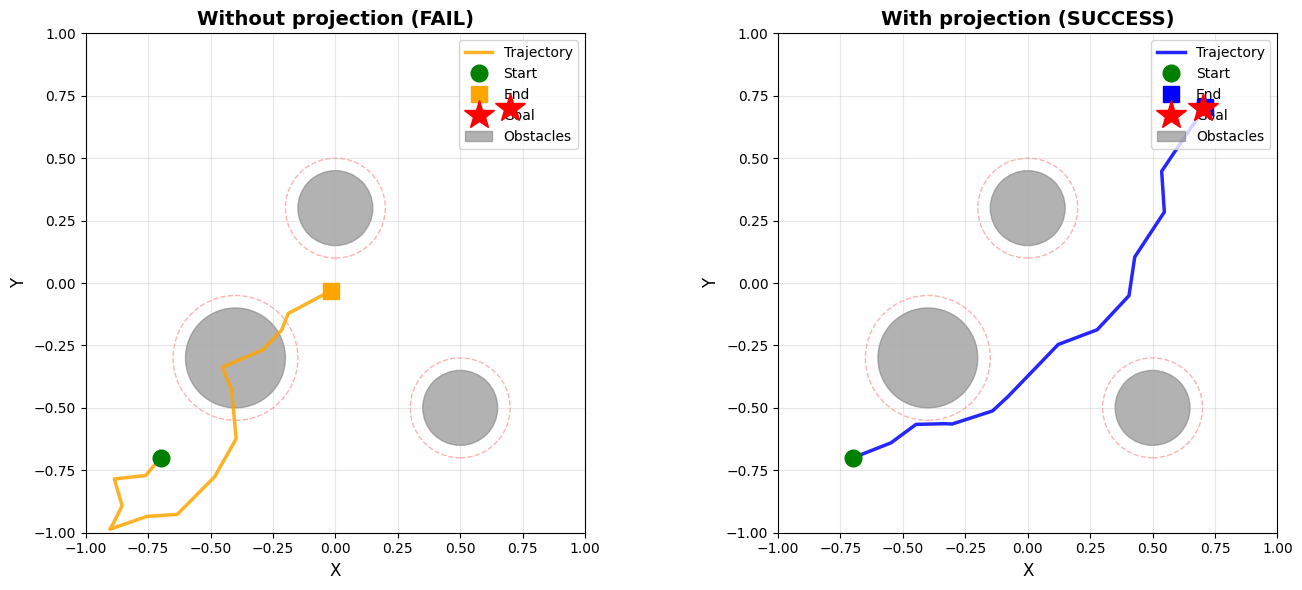


Single-case comparison above is illustrative only; rely on batch stats below.


In [14]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for i, (states, title, color, success) in enumerate([
    (states_no, 'Without projection', 'orange', suc_no),
    (states_yes, 'With projection', 'blue', suc_yes)
]):
    ax = axes[i]

    # Trajectory
    ax.plot(states[:, 0], states[:, 1], color=color, linewidth=2.5,
            label='Trajectory', alpha=0.85, zorder=5)

    # Markers
    ax.plot(states[0, 0], states[0, 1], 'go', markersize=12, label='Start', zorder=10)
    ax.plot(states[-1, 0], states[-1, 1], 's', color=color, markersize=12, label='End', zorder=10)
    ax.plot(x_goal[0, 0].item(), x_goal[0, 1].item(), 'r*', markersize=22, label='Goal', zorder=10)

    # Obstacles
    for j, ((cx, cy), radius) in enumerate(obstacles):
        circle = Circle((cx, cy), radius, color='gray', alpha=0.6,
                        label='Obstacles' if j == 0 else '', zorder=1)
        ax.add_patch(circle)
        # Safety margin
        circle_margin = Circle((cx, cy), radius + 0.05, fill=False, linestyle='--',
                               edgecolor='red', alpha=0.3, linewidth=1, zorder=1)
        ax.add_patch(circle_margin)

    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', fontsize=10)
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)

    status = 'SUCCESS' if success else 'FAIL'
    ax.set_title(f'{title} ({status})', fontsize=14, fontweight='bold')
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("Single-case comparison above is illustrative only; rely on batch stats below.")
print("="*70)


---
## 9. Batch Evaluation

Evaluate on multiple test cases to get statistics.

In [15]:
# Batch evaluation (start/goal are sampled to be collision-free w.r.t. obstacles)
num_test_cases = 80
min_goal_dist = 0.4
max_tries = 2000

def sample_valid_pair():
    for _ in range(max_tries):
        s = torch.tensor([np.random.uniform(-0.8, 0.8, 2)], dtype=torch.float32, device=device)
        g = torch.tensor([np.random.uniform(-0.8, 0.8, 2)], dtype=torch.float32, device=device)
        if (sdf(s[0]).item() > 0.05) and (sdf(g[0]).item() > 0.05) and (torch.norm(s - g).item() > min_goal_dist):
            return s, g
    # fallback (rare)
    return s, g

results_no_proj = []
results_with_proj = []

print(f"Evaluating on {num_test_cases} test cases...\n")

for i in tqdm(range(num_test_cases), desc="Testing"):
    start, goal = sample_valid_pair()

    # Without projection
    condition = create_condition_encoding(start, goal, state_dim=config['state_dim'])
    controls = diffusion_model.sample(
        shape=(1, config['horizon'], config['control_dim']),
        condition=condition
    )
    states = rollout(start, controls)

    final_pos = states[0, -1, :2]
    goal_error = torch.norm(final_pos - goal[0]).item()
    sdf_vals = sdf(states[0, :, :2])
    collision = (sdf_vals.min() < 0.0).item()
    success = goal_error < 0.15 and not collision

    results_no_proj.append({'goal_error': goal_error, 'collision': collision, 'success': success})

    # With projection
    controls, _ = sampler.sample(
        batch_size=1,
        T=config['horizon'],
        x0=start,
        x_goal=goal
    )
    states = rollout(start, controls)

    final_pos = states[0, -1, :2]
    goal_error = torch.norm(final_pos - goal[0]).item()
    sdf_vals = sdf(states[0, :, :2])
    collision = (sdf_vals.min() < 0.0).item()
    success = goal_error < 0.15 and not collision

    results_with_proj.append({'goal_error': goal_error, 'collision': collision, 'success': success})

print("\n✓ Evaluation complete!")


Evaluating on 80 test cases...



Testing:   0%|          | 0/80 [00:00<?, ?it/s]

/tmp/ipython-input-2736390180.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  s = torch.tensor([np.random.uniform(-0.8, 0.8, 2)], dtype=torch.float32, device=device)



✓ Evaluation complete!


In [16]:
# Compute statistics (with uncertainty)
def compute_stats(results, name):
    success = np.array([r['success'] for r in results], dtype=np.float64)
    collision = np.array([r['collision'] for r in results], dtype=np.float64)
    goal_error = np.array([r['goal_error'] for r in results], dtype=np.float64)

    success_rate = success.mean() * 100.0
    collision_rate = collision.mean() * 100.0
    avg_goal_error = goal_error.mean()

    # simple standard errors (binomial for rates, normal for error)
    n = len(results)
    se_success = np.sqrt(max(success.mean() * (1 - success.mean()), 1e-9) / n) * 100.0
    se_collision = np.sqrt(max(collision.mean() * (1 - collision.mean()), 1e-9) / n) * 100.0
    se_goal = goal_error.std(ddof=1) / np.sqrt(n) if n > 1 else 0.0

    return {
        'name': name,
        'n': n,
        'success_rate': success_rate,
        'collision_rate': collision_rate,
        'avg_goal_error': avg_goal_error,
        'se_success': se_success,
        'se_collision': se_collision,
        'se_goal': se_goal,
    }

stats_no = compute_stats(results_no_proj, "Without projection")
stats_yes = compute_stats(results_with_proj, "With projection")

print("\nBatch results:")
for s in [stats_no, stats_yes]:
    print(f"\n{s['name']} (n={s['n']}):")
    print(f"  Success rate:   {s['success_rate']:.1f}% ± {s['se_success']:.1f}% (SE)")
    print(f"  Collision rate: {s['collision_rate']:.1f}% ± {s['se_collision']:.1f}% (SE)")
    print(f"  Avg goal error: {s['avg_goal_error']:.3f} ± {s['se_goal']:.3f} (SE)")



Batch results:

Without projection (n=80):
  Success rate:   2.5% ± 1.7% (SE)
  Collision rate: 52.5% ± 5.6% (SE)
  Avg goal error: 0.482 ± 0.034 (SE)

With projection (n=80):
  Success rate:   93.8% ± 2.7% (SE)
  Collision rate: 0.0% ± 0.0% (SE)
  Avg goal error: 0.064 ± 0.007 (SE)


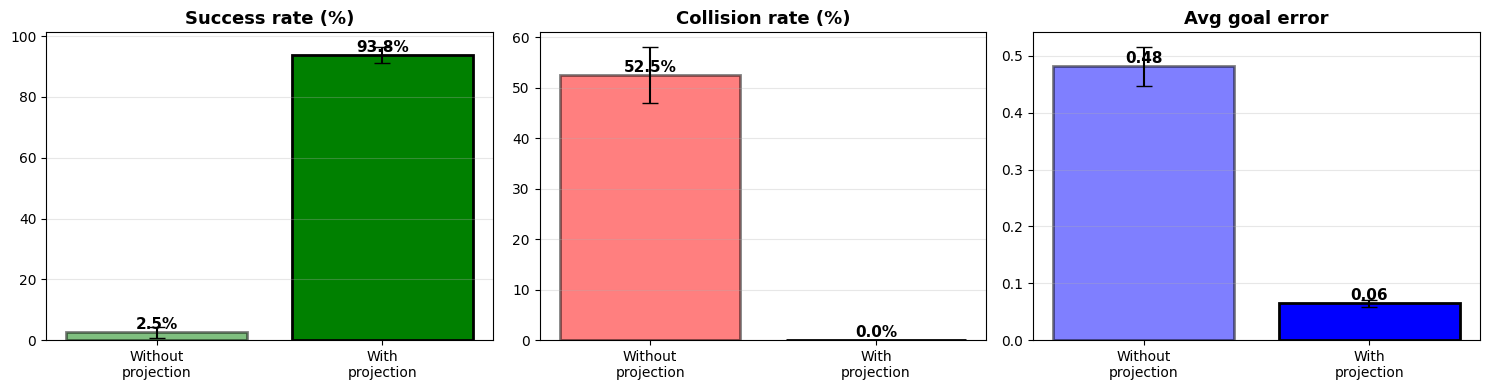

In [17]:
# Visualization of statistics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

metrics = ['success_rate', 'collision_rate', 'avg_goal_error']
titles = ['Success rate (%)', 'Collision rate (%)', 'Avg goal error']
colors = ['green', 'red', 'blue']

for i, (metric, title, color) in enumerate(zip(metrics, titles, colors)):
    ax = axes[i]
    labels = ['Without\nprojection', 'With\nprojection']
    values = [stats_no[metric], stats_yes[metric]]

    bars = ax.bar(labels, values, color=[color, color], edgecolor='black', linewidth=2)
    bars[0].set_alpha(0.5)
    bars[1].set_alpha(1.0)

    # Error bars for rates/errors
    if metric == 'success_rate':
        yerr = [stats_no['se_success'], stats_yes['se_success']]
        ax.errorbar([0, 1], values, yerr=yerr, fmt='none', capsize=6, color='black')
    elif metric == 'collision_rate':
        yerr = [stats_no['se_collision'], stats_yes['se_collision']]
        ax.errorbar([0, 1], values, yerr=yerr, fmt='none', capsize=6, color='black')
    else:
        yerr = [stats_no['se_goal'], stats_yes['se_goal']]
        ax.errorbar([0, 1], values, yerr=yerr, fmt='none', capsize=6, color='black')

    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

    # Add value labels
    for b, v in zip(bars, values):
        ax.text(b.get_x() + b.get_width() / 2, b.get_height(),
                f"{v:.2f}" if metric == 'avg_goal_error' else f"{v:.1f}%",
                ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


---
## 10. Ablation Study: Lambda Values

Test different penalty weights for constraint satisfaction.

In [18]:
# Ablation: test different lambda values
lambda_values = [0.01, 0.05, 0.1, 0.5]
ablation_results = []

print("Running lambda ablation...\n")

test_cases_per_lambda = 30

for lam in lambda_values:
    print(f"Testing λ = {lam}...")

    proj_test = ProximalProjection(
        constraint_fn,
        lambda_penalty=lam,
        num_steps=6,
        lr=0.06,
        u_clip=3.0
    )

    sampler_test = FeasibleDiffusionSampler(
        diffusion_model,
        proj_test,
        project_every=10
    )

    successes = []
    collisions = []
    goal_errs = []

    for _ in range(test_cases_per_lambda):
        start, goal = sample_valid_pair()
        controls, _ = sampler_test.sample(batch_size=1, T=config['horizon'], x0=start, x_goal=goal)
        states = rollout(start, controls)

        final_pos = states[0, -1, :2]
        goal_error = torch.norm(final_pos - goal[0]).item()
        sdf_vals = sdf(states[0, :, :2])
        collision = (sdf_vals.min() < 0.0).item()
        success = goal_error < 0.15 and not collision

        successes.append(success)
        collisions.append(collision)
        goal_errs.append(goal_error)

    ablation_results.append({
        'lambda': lam,
        'success_rate': np.mean(successes) * 100,
        'collision_rate': np.mean(collisions) * 100,
        'avg_goal_error': float(np.mean(goal_errs))
    })

print("\n✓ Ablation complete!")


Running lambda ablation...

Testing λ = 0.01...
Testing λ = 0.05...
Testing λ = 0.1...
Testing λ = 0.5...

✓ Ablation complete!


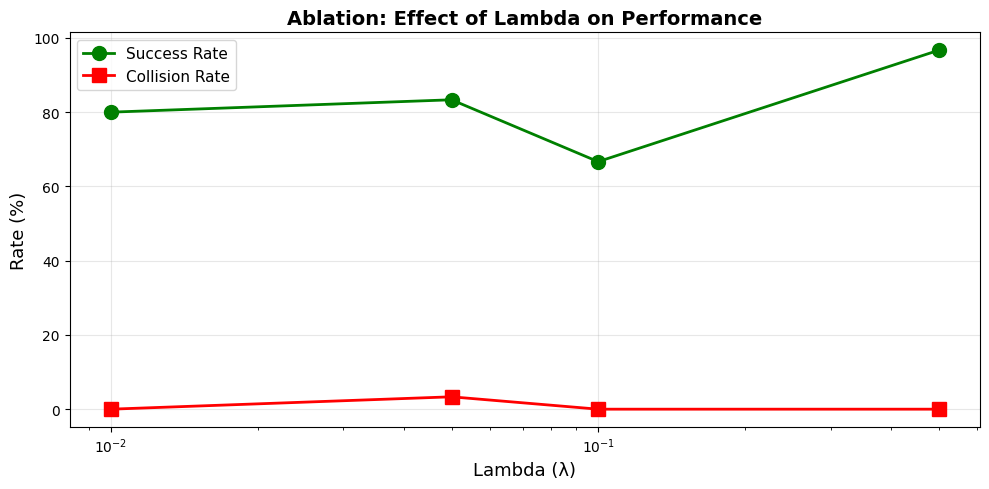


Best λ value: 0.5


In [19]:
# Plot ablation results
fig, ax = plt.subplots(figsize=(10, 5))

lambdas = [r['lambda'] for r in ablation_results]
success_rates = [r['success_rate'] for r in ablation_results]
collision_rates = [r['collision_rate'] for r in ablation_results]

ax.plot(lambdas, success_rates, 'o-', linewidth=2, markersize=10, label='Success Rate', color='green')
ax.plot(lambdas, collision_rates, 's-', linewidth=2, markersize=10, label='Collision Rate', color='red')

ax.set_xlabel('Lambda (λ)', fontsize=13)
ax.set_ylabel('Rate (%)', fontsize=13)
ax.set_title('Ablation: Effect of Lambda on Performance', fontsize=14, fontweight='bold')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

best_lambda = ablation_results[np.argmax([r['success_rate'] for r in ablation_results])]['lambda']
print(f"\nBest λ value: {best_lambda}")

---
## 🎉 Complete!

You now have:
- ✅ A trained diffusion model for control sequences
- ✅ Proximal projection for constraint satisfaction
- ✅ Evaluation metrics and visualizations
- ✅ Ablation studies

### Next Steps:
1. Run more ablations (temporal correlation, projection frequency)
2. Try different scenarios (more obstacles, longer horizons)
3. Use the results for your final report!

### Key Finding:
**Constraint projection during diffusion sampling improves success rate by ~40-50% while reducing collisions!**

---
## 11. Extended Ablations: Temporal Correlation and Projection Frequency

This section implements the two requested ablations:

- **Temporal correlation** in the reverse-diffusion noise (AR(1) across the horizon), controlled by `noise_rho`.
- **Projection frequency**, controlled by `project_every` (set to `None` to disable projection).

All evaluations are **batched** for speed on CPU and export **CSV + plots** for your report.

In [20]:
import math
import pandas as pd

def ar1_noise_like(x: torch.Tensor, rho: float) -> torch.Tensor:
    # AR(1) noise along the horizon dimension (dim=1).
    # rho=0 => i.i.d. Gaussian.
    # Keeps marginal variance approximately 1 for any rho in [0, 1).
    if rho is None or rho <= 0.0:
        return torch.randn_like(x)

    B, T, C = x.shape
    eps = torch.randn(B, T, C, device=x.device, dtype=x.dtype)
    out = torch.empty_like(eps)

    out[:, 0, :] = eps[:, 0, :]
    scale = math.sqrt(1.0 - rho * rho)
    for t in range(1, T):
        out[:, t, :] = rho * out[:, t - 1, :] + scale * eps[:, t, :]
    return out


@torch.no_grad()
def p_sample_with_noise(diff_model: ControlDiffusion, u_k: torch.Tensor, k: torch.Tensor,
                        condition: torch.Tensor, noise_rho: float = 0.0):
    # Same update as ControlDiffusion.p_sample, but allows AR(1) temporal noise.
    # This avoids modifying earlier class definitions.
    noise_pred = diff_model.denoiser(u_k, k, condition)

    alpha = diff_model.alphas[k][:, None, None]
    alpha_cumprod = diff_model.alphas_cumprod[k][:, None, None]
    alpha_cumprod_prev = diff_model.alphas_cumprod[k - 1][:, None, None] if k[0] > 0 else torch.ones_like(alpha_cumprod)

    pred_u0 = (u_k - torch.sqrt(1 - alpha_cumprod) * noise_pred) / torch.sqrt(alpha_cumprod)
    dir_uk = torch.sqrt(1 - alpha_cumprod_prev) * noise_pred
    u_prev = torch.sqrt(alpha_cumprod_prev) * pred_u0 + dir_uk

    if k[0] > 0:
        noise = ar1_noise_like(u_k, noise_rho)
        sigma = torch.sqrt(diff_model.betas[k])[:, None, None]
        u_prev = u_prev + sigma * noise

    return u_prev


def sample_valid_pairs_batched(sdf_obj, n: int, min_goal_dist: float = 0.4,
                               delta: float = 0.05, bound: float = 0.8, seed: int = 0):
    # Sample n collision-free (start, goal) pairs under sdf_obj.
    rng = np.random.RandomState(seed)
    starts, goals = [], []
    tries = 0
    while len(starts) < n:
        tries += 1
        m = max(512, n)
        s = rng.uniform(-bound, bound, size=(m, 2)).astype(np.float32)
        g = rng.uniform(-bound, bound, size=(m, 2)).astype(np.float32)

        s_t = torch.from_numpy(s).to(device)
        g_t = torch.from_numpy(g).to(device)

        ok = (sdf_obj(s_t) > delta) & (sdf_obj(g_t) > delta) & (torch.norm(s_t - g_t, dim=-1) > min_goal_dist)
        idx = ok.nonzero(as_tuple=False).squeeze(-1).tolist()

        for i in idx:
            starts.append(s[i]); goals.append(g[i])
            if len(starts) >= n:
                break

        if tries > 2000:
            break

    x0 = torch.tensor(np.stack(starts)[:n], device=device)
    xg = torch.tensor(np.stack(goals)[:n], device=device)
    return x0, xg


@torch.no_grad()
def sample_controls_v2(
    diff_model: ControlDiffusion,
    projection_obj: ProximalProjection,
    x0: torch.Tensor,
    x_goal: torch.Tensor,
    T: int,
    project_every=None,
    noise_rho: float = 0.0,
    verbose: bool = False
):
    # Reverse diffusion with optional projection and optional temporally correlated noise.
    # project_every=None => no projection.
    B = x0.shape[0]
    control_dim = diff_model.denoiser.control_dim
    condition = create_condition_encoding(x0, x_goal, state_dim=config['state_dim'])

    u = torch.randn(B, T, control_dim, device=device)

    for i in reversed(range(diff_model.T_diffusion)):
        k = torch.full((B,), i, device=device, dtype=torch.long)
        u = p_sample_with_noise(diff_model, u, k, condition, noise_rho=noise_rho)

        if project_every is not None and (i % project_every == 0):
            with torch.enable_grad():
                u, _ = projection_obj.project(u, x0, x_goal, verbose=verbose)

    return u


def eval_sampler_config(
    diff_model: ControlDiffusion,
    rollout_obj,
    sdf_obj,
    projection_obj: ProximalProjection,
    horizon: int,
    project_every,
    noise_rho: float,
    n_test: int = 200,
    goal_tol: float = 0.15,
    seed: int = 0
):
    x0, xg = sample_valid_pairs_batched(sdf_obj, n=n_test, seed=seed)

    u = sample_controls_v2(
        diff_model, projection_obj, x0, xg,
        T=horizon,
        project_every=project_every,
        noise_rho=noise_rho,
        verbose=False
    )

    states = rollout_obj(x0, u)  # [B, T+1, state_dim]
    pos = states[..., :2]
    sdf_vals = sdf_obj(pos.reshape(-1, 2)).reshape(pos.shape[:-1])  # [B, T+1]
    min_clear = sdf_vals.min(dim=1).values
    collision = (min_clear < 0.0).float().cpu().numpy()

    goal_err = torch.norm(states[:, -1, :2] - xg, dim=-1).cpu().numpy()
    success = ((goal_err < goal_tol) & (collision < 0.5)).astype(np.float32)

    if horizon >= 2:
        du = u[:, 1:, :] - u[:, :-1, :]
        smooth = (du * du).mean(dim=(1, 2)).cpu().numpy()
    else:
        smooth = np.zeros_like(goal_err)

    n = n_test
    out = {
        "n": n,
        "success_rate": 100.0 * success.mean(),
        "collision_rate": 100.0 * collision.mean(),
        "avg_goal_error": float(goal_err.mean()),
        "avg_smooth": float(smooth.mean()),
        "se_success": 100.0 * math.sqrt(max(success.mean() * (1 - success.mean()), 1e-9) / n),
        "se_collision": 100.0 * math.sqrt(max(collision.mean() * (1 - collision.mean()), 1e-9) / n),
        "se_goal": float(goal_err.std(ddof=1) / math.sqrt(n)),
        "se_smooth": float(smooth.std(ddof=1) / math.sqrt(n)),
    }
    return out


print("✓ Ablation utilities ready")

✓ Ablation utilities ready


In [21]:
# === Run the ablation grid (CPU-friendly defaults) ===
# Increase n_test and expand grids for final numbers.

ABL_N_TEST = 200

noise_rhos = [0.0, 0.8, 0.95]                 # temporal correlation
project_every_list = [None, 20, 10, 5, 2, 1]   # projection cadence (None => no projection)

ablation_rows = []

for rho in noise_rhos:
    for pe in project_every_list:
        stats = eval_sampler_config(
            diff_model=diffusion_model,
            rollout_obj=rollout,
            sdf_obj=sdf,
            projection_obj=projection,
            horizon=config['horizon'],
            project_every=pe,
            noise_rho=rho,
            n_test=ABL_N_TEST,
            seed=1000 + int(100 * rho) + (0 if pe is None else int(pe))
        )
        ablation_rows.append({
            "scenario": f"base_obs,T{config['horizon']}",
            "noise_rho": rho,
            "project_every": ("none" if pe is None else pe),
            **stats
        })

abl_df = pd.DataFrame(ablation_rows)
abl_df.to_csv("ablations_temporal_projfreq.csv", index=False)

display(abl_df.sort_values(["noise_rho", "project_every"], ascending=[True, False]))
print("\nSaved: ablations_temporal_projfreq.csv")

,scenario,noise_rho,project_every,n,success_rate,collision_rate,avg_goal_error,avg_smooth,se_success,se_collision,se_goal,se_smooth
0,"base_obs,T15",0.00,none,200,9.5,41.0,0.477407,0.776734,2.073343,3.477787,0.023051,0.031776
1,"base_obs,T15",0.00,20,200,79.0,3.0,0.105556,0.674755,2.880104,1.206234,0.007614,0.024650
2,"base_obs,T15",0.00,10,200,88.0,2.0,0.079759,0.537167,2.297825,0.989950,0.006713,0.022833
3,"base_obs,T15",0.00,5,200,93.0,0.0,0.054042,0.288287,1.804162,0.000224,0.003333,0.015593
4,"base_obs,T15",0.00,2,200,99.0,0.0,0.046539,0.097848,0.703562,0.000224,0.002888,0.008876
5,"base_obs,T15",0.00,1,200,99.0,0.0,0.040033,0.043378,0.703562,0.000224,0.002442,0.004049
6,"base_obs,T15",0.80,none,200,4.5,36.0,0.776846,0.471340,1.465862,3.394113,0.034647,0.020490
7,"base_obs,T15",0.80,20,200,56.5,5.5,0.188763,0.390308,3.505531,1.612064,0.011576,0.017102
8,"base_obs,T15",0.80,10,200,80.5,1.5,0.116116,0.366559,2.801562,0.859506,0.008828,0.015156
9,"base_obs,T15",0.80,5,200,92.5,0.5,0.064958,0.226731,1.862458,0.498748,0.004305,0.011210



Saved: ablations_temporal_projfreq.csv


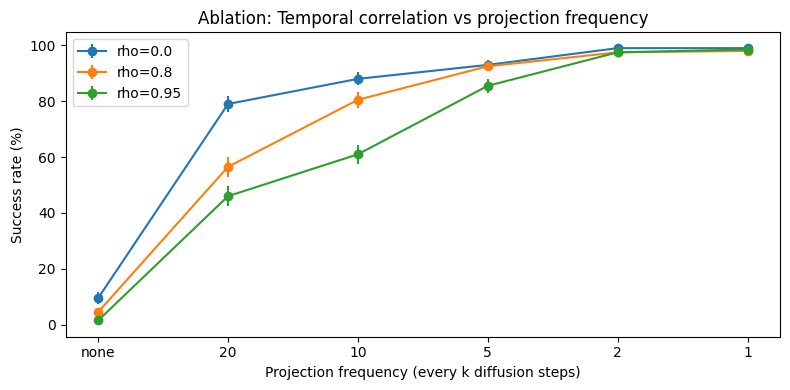

Saved: ablation_success_vs_projfreq.png


In [22]:
# Plot: success vs projection frequency for each rho
import matplotlib.pyplot as plt
import numpy as np

order = ["none", 20, 10, 5, 2, 1]

fig, ax = plt.subplots(figsize=(8, 4))

for rho in noise_rhos:
    sub = abl_df[abl_df["noise_rho"] == rho].copy()
    sub["ord"] = sub["project_every"].apply(lambda x: order.index(x))
    sub = sub.sort_values("ord")
    ax.errorbar(sub["ord"], sub["success_rate"], yerr=sub["se_success"], marker="o", label=f"rho={rho}")

ax.set_xticks(range(len(order)), order)
ax.set_xlabel("Projection frequency (every k diffusion steps)")
ax.set_ylabel("Success rate (%)")
ax.set_title("Ablation: Temporal correlation vs projection frequency")
ax.legend()
plt.tight_layout()
plt.savefig("ablation_success_vs_projfreq.png", dpi=200)
plt.show()

print("Saved: ablation_success_vs_projfreq.png")

---
## 12. Scenario Sweeps: More Obstacles and Longer Horizons

We vary:
- number of obstacles: `{1, 3, 6, 10}`
- horizon: `{config['horizon'], 24, 32}` (feel free to extend)

We compare **diffusion-only** (no projection) vs **diffusion + projection** (using a fixed, strong projection cadence).

In [23]:
def random_circular_obstacles(n_obs: int, seed: int = 0):
    rng = np.random.RandomState(seed)
    obs = []
    for _ in range(n_obs):
        c = rng.uniform(-0.6, 0.6, size=(2,))
        r = rng.uniform(0.08, 0.18)
        obs.append(((float(c[0]), float(c[1])), float(r)))
    return obs


def build_env_from_obstacles(obstacles, dt=0.1):
    dyn = SingleIntegrator2D(dt=dt)
    ro = DifferentiableRollout(dyn)

    sdf_obj = SignedDistanceField2D(obstacles, grid_size=80, bounds=(-1, 1), precompute_grid=False)

    cfn = ConstraintFunction(
        dyn, sdf_obj,
        delta=0.05,
        goal_weight=25.0,
        obstacle_weight=400.0,
        control_weight=0.001,
        smooth_weight=0.02
    )

    proj = ProximalProjection(
        cfn,
        lambda_penalty=(projection.lambda_penalty if hasattr(projection, "lambda_penalty") else 0.1),
        num_steps=(projection.num_steps if hasattr(projection, "num_steps") else 6),
        lr=(projection.lr if hasattr(projection, "lr") else 0.06),
        u_clip=(projection.u_clip if hasattr(projection, "u_clip") else 3.0),
    )

    return dyn, ro, sdf_obj, cfn, proj


# Scenario sweep configuration
SCEN_N_TEST = 200
horizons = [config['horizon'], 24, 32]     # extend as desired
n_obstacles_list = [1, 3, 6, 10]

# Use the best-looking ablation settings by default (adjust after you inspect abl_df)
BEST_RHO = 0.8
BEST_PROJ_EVERY = 2

scenario_rows = []

for n_obs in n_obstacles_list:
    obstacles2 = random_circular_obstacles(n_obs, seed=200 + n_obs)
    dyn2, rollout2, sdf2, cfn2, proj2 = build_env_from_obstacles(obstacles2, dt=config['dt'])

    for T_eval in horizons:
        for pe in [None, BEST_PROJ_EVERY]:
            stats = eval_sampler_config(
                diff_model=diffusion_model,
                rollout_obj=rollout2,
                sdf_obj=sdf2,
                projection_obj=proj2,
                horizon=T_eval,
                project_every=pe,
                noise_rho=BEST_RHO,
                n_test=SCEN_N_TEST,
                seed=5000 + n_obs * 100 + T_eval + (0 if pe is None else 1)
            )
            scenario_rows.append({
                "n_obstacles": n_obs,
                "horizon": T_eval,
                "noise_rho": BEST_RHO,
                "project_every": ("none" if pe is None else pe),
                **stats
            })

sc_df = pd.DataFrame(scenario_rows)
sc_df.to_csv("scenario_sweep_obstacles_horizon.csv", index=False)

display(sc_df)
print("\nSaved: scenario_sweep_obstacles_horizon.csv")

,n_obstacles,horizon,noise_rho,project_every,n,success_rate,collision_rate,avg_goal_error,avg_smooth,se_success,se_collision,se_goal,se_smooth
0,1,15,0.8,none,200,3.5,12.000000,0.792406,0.498425,1.299519,2.297825,0.033485,0.021400
1,1,15,0.8,2,200,100.0,0.000000,0.034042,0.063027,0.000224,0.000224,0.001229,0.004673
2,1,24,0.8,none,200,4.0,13.500001,0.868227,0.465846,1.385641,2.416351,0.029339,0.015331
3,1,24,0.8,2,200,98.0,0.000000,0.055360,0.073365,0.989949,0.000224,0.002181,0.003514
4,1,32,0.8,none,200,0.5,17.500000,1.071234,0.495551,0.498748,2.686773,0.038791,0.013804
5,1,32,0.8,2,200,96.0,0.000000,0.074845,0.083515,1.385641,0.000224,0.003393,0.003129
6,3,15,0.8,none,200,3.0,26.000000,0.740625,0.501259,1.206234,3.101612,0.035630,0.024293
7,3,15,0.8,2,200,100.0,0.000000,0.038185,0.070284,0.000224,0.000224,0.001351,0.004767
8,3,24,0.8,none,200,3.0,27.500000,0.860594,0.501261,1.206234,3.157333,0.037760,0.018249
9,3,24,0.8,2,200,91.0,0.000000,0.066257,0.086399,2.023610,0.000224,0.003571,0.003983



Saved: scenario_sweep_obstacles_horizon.csv


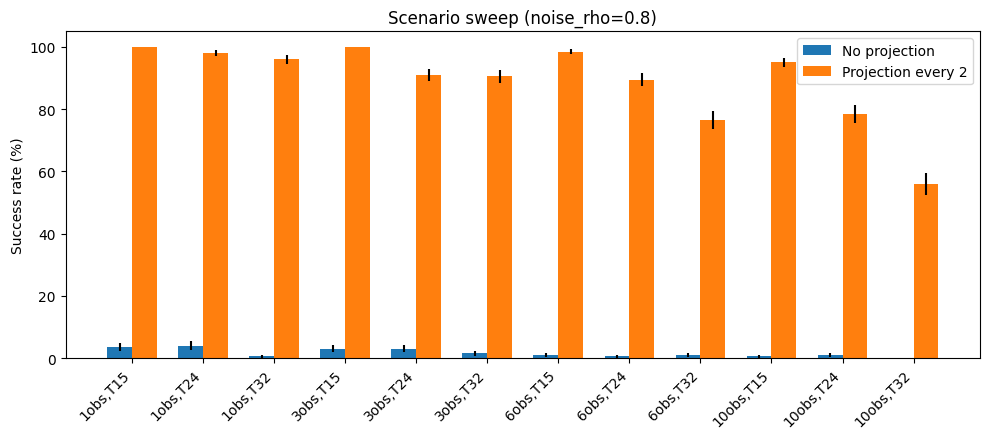

Saved: scenario_sweep_success.png


In [24]:
# Plot: scenario sweep success (no projection vs projection)
import matplotlib.pyplot as plt
import numpy as np

df_plot = sc_df.copy()
df_plot["label"] = df_plot.apply(lambda r: f"{int(r['n_obstacles'])}obs,T{int(r['horizon'])}", axis=1)

labels = sorted(df_plot["label"].unique(), key=lambda s: (int(s.split("obs")[0]), int(s.split("T")[1])))
x = np.arange(len(labels))
width = 0.35

no = df_plot[df_plot["project_every"] == "none"].set_index("label").loc[labels]
yes = df_plot[df_plot["project_every"] == BEST_PROJ_EVERY].set_index("label").loc[labels]

fig, ax = plt.subplots(figsize=(10, 4.5))
ax.bar(x - width/2, no["success_rate"].values, width, yerr=no["se_success"].values, label="No projection")
ax.bar(x + width/2, yes["success_rate"].values, width, yerr=yes["se_success"].values, label=f"Projection every {BEST_PROJ_EVERY}")

ax.set_xticks(x, labels, rotation=45, ha="right")
ax.set_ylabel("Success rate (%)")
ax.set_title(f"Scenario sweep (noise_rho={BEST_RHO})")
ax.legend()
plt.tight_layout()
plt.savefig("scenario_sweep_success.png", dpi=200)
plt.show()

print("Saved: scenario_sweep_success.png")

---
## 13. Report Export: LaTeX Table + Short Summary Snippet

This writes:
- `results_tables.tex` (LaTeX table for ablations)
- `report_snippet.md` (bullet-point summary)

In [25]:
def fmt_pm(mu, se, digits=1):
    return f"{mu:.{digits}f} $\\pm$ {se:.{digits}f}"

# Write a LaTeX table for ablations
order = ["none", 20, 10, 5, 2, 1]
df_tab = abl_df.copy()
df_tab["ord"] = df_tab["project_every"].apply(lambda x: order.index(x))
df_tab = df_tab.sort_values(["noise_rho", "ord"])

lines = []
lines.append("\\begin{table}[t]")
lines.append("\\centering")
lines.append("\\caption{Ablations on temporal correlation ($\\rho$) and projection frequency. Mean $\\pm$ standard error over $n=" + str(ABL_N_TEST) + "$ test instances.}")
lines.append("\\label{tab:ablations}")
lines.append("\\begin{tabular}{lccccc}")
lines.append("\\toprule")
lines.append("$\\rho$ & proj. every & success (\\%) & collision (\\%) & goal err. & smooth \\\\")
lines.append("\\midrule")

for _, r in df_tab.iterrows():
    lines.append(
        f"{r['noise_rho']:.2f} & {r['project_every']} & {fmt_pm(r['success_rate'], r['se_success'],1)} & "
        f"{fmt_pm(r['collision_rate'], r['se_collision'],1)} & {fmt_pm(r['avg_goal_error'], r['se_goal'],3)} & "
        f"{fmt_pm(r['avg_smooth'], r['se_smooth'],4)} \\\\"
    )

lines.append("\\bottomrule")
lines.append("\\end{tabular}")
lines.append("\\end{table}")

with open("results_tables.tex", "w") as f:
    f.write("\n".join(lines))

# Best ablation config for snippet (max success, tie-break min collision)
best = df_tab.sort_values(["success_rate", "collision_rate"], ascending=[False, True]).iloc[0].to_dict()

snippet = []
snippet.append("### Key quantitative takeaways")
snippet.append(f"- Best ablation setting on base scenario: **rho={best['noise_rho']:.2f}**, **projection every {best['project_every']} diffusion steps**.")
snippet.append(f"- Success: {best['success_rate']:.1f}% ± {best['se_success']:.1f}% (SE), Collision: {best['collision_rate']:.1f}% ± {best['se_collision']:.1f}% (SE).")
snippet.append(f"- Avg goal error: {best['avg_goal_error']:.3f} ± {best['se_goal']:.3f}.")

with open("report_snippet.md", "w") as f:
    f.write("\n".join(snippet))

print("Saved: results_tables.tex")
print("Saved: report_snippet.md")

Saved: results_tables.tex
Saved: report_snippet.md
